In [59]:
%cd /home/alvarovh/code/cse598_climate_proj/climate-physicsML/final_combined_loss_model

/home/alvarovh/code/cse598_climate_proj/climate-physicsML/final_combined_loss_model


In [60]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle


def load_model(model_path):
    """Load the trained model."""
    print(f"Loading model from {model_path}...")
    model = keras.models.load_model(model_path, compile=False)
    model.summary()
    return model

def preprocess_data(input_file, vars_mli, mli_mean, mli_max, mli_min):
    """Preprocess input data for prediction."""
    ds = xr.open_dataset(input_file, engine="netcdf4")
    ds = ds[vars_mli]
    # ds_normalized = (ds - mli_mean) / (mli_max - mli_min)
    ds["state_t"] = ds["state_t"][0]
    ds["state_q0001"] = ds["state_q0001"][0]
    return ds.stack({"batch": {"ncol"}}).to_stacked_array(
        "mlvar", sample_dims=["batch"], name="mli"
    ).values

# def postprocess_predictions(predictions, mlo_scale):
#     """Postprocess model predictions to scale them back to original units."""
#     predictions_rescaled = predictions / mlo_scale
#     return predictions_rescaled
def postprocess_predictions(predictions, mlo_scale, vars_mlo):
    """Postprocess model predictions to scale them back to original units."""
    # Ensure mlo_scale contains only the relevant variables
    mlo_scale = mlo_scale[vars_mlo]



    # Stack scaling factors to align with predictions
    mlo_scale_stacked = mlo_scale.stack({'new_dim': mlo_scale.dims}).to_stacked_array(
        'mlvar', sample_dims=["new_dim"], name='mlo'
    )
    # Extract scaling factors as numpy array
    scaling_factors = mlo_scale_stacked.values
    
    # Ensure scaling factors align with predictions
    if scaling_factors.shape[0] != predictions.shape[1]:
        raise ValueError(
            f"Shape mismatch: scaling_factors shape {scaling_factors.shape} "
            f"does not match predictions shape {predictions.shape}. Ensure the variables align correctly."
        )
    
    # Rescale predictions
    predictions_rescaled = predictions * scaling_factors
    return predictions_rescaled

def make_predictions(input_file, model, vars_mli, vars_mlo, mli_mean, mli_max, mli_min, mlo_scale, output_dir):
    """Make predictions and save results."""
    print(f"Processing input file: {input_file}")
    input_data = preprocess_data(input_file, vars_mli, mli_mean, mli_max, mli_min)
    predictions = model.predict(input_data)
    return predictions, input_data, vars_mlo, mlo_scale
    predictions_rescaled = postprocess_predictions(predictions, mlo_scale, vars_mlo)

    # Load ground truth
    ds_ground_truth = xr.open_dataset(
        input_file.replace(".mli.", ".mlo."), engine="netcdf4"
    )
    ds_ground_truth = ds_ground_truth[vars_mlo].stack({"batch": {"lev"}}).to_stacked_array(
        "mlvar", sample_dims=["batch"], name="mlo"
    ).values

    # Save predictions and ground truth for comparison
    output_file = os.path.join(output_dir, "predictions_vs_ground_truth.nc")
    print(f"Saving predictions and ground truth to {output_file}")
    xr.Dataset(
        {
            "predictions": (["batch", "mlvar"], predictions_rescaled),
            "ground_truth": (["batch", "mlvar"], ds_ground_truth),
        }
    ).to_netcdf(output_file)

    return predictions_rescaled, ds_ground_truth

def plot_comparison(predictions, ground_truth, vars_mlo, output_dir):
    """Visualize predictions vs ground truth for key variables."""
    for i, var in enumerate(vars_mlo):
        plt.figure(figsize=(12, 8))
        plt.plot(ground_truth[:, i], label=f"Ground Truth ({var})", alpha=0.7)
        plt.plot(predictions[:, i], label=f"Predictions ({var})", alpha=0.7)
        plt.title(f"Comparison: {var}", fontsize=16)
        plt.xlabel("Batch", fontsize=14)
        plt.ylabel(var, fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.6)

        output_file = os.path.join(output_dir, f"comparison_{var}.png")
        plt.savefig(output_file)
        plt.close()
        print(f"Saved comparison plot: {output_file}")


In [61]:

with open("file_list.pkl", "rb") as f:
    all_files = pickle.load(f)
    print("Loaded file list from file_list.pkl.")

Loaded file list from file_list.pkl.


In [62]:
all_files[0]

'/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all//datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0006-07/E3SM-MMF.mli.0006-07-06-43200.nc'

In [63]:
# Define paths
input_file = all_files[-1]  # Replace with your .mli file
groundtruth_file = input_file.replace(".mli.", ".mlo.")  # Replace with your .mlo file
# model_path = "/home/alvarovh/code/cse598_climate_proj/results/results_0.1/best_model_lambda_0.0_datafrac_0.1_epoch_3.keras"  # Replace with your model path
# model_path = "/home/alvarovh/code/cse598_climate_proj/results/results_0.01/best_model_lambda_0.0_datafrac_0.01_epoch_1.keras"  # Replace with your model path
model_path = "/home/alvarovh/code/cse598_climate_proj/results/results_0.01/best_model_lambda_0.1_datafrac_0.01_epoch_1.keras"
output_dir = "out_model_figures"  # Replace with your output directory
norm_path = "/home/alvarovh/code/cse598_climate_proj/ClimSim/preprocessing/normalizations/"  # Replace with your normalization files path

# Variables for input (mli) and output (mlo)
vars_mli = [
    "state_t", "state_q0001", "state_ps", "pbuf_SOLIN", "pbuf_LHFLX", "pbuf_SHFLX", "cam_in_LWUP"
]

vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']


In [64]:
# Load normalization data
mli_mean = xr.open_dataset(os.path.join(norm_path, "inputs/input_mean.nc"))
mli_max = xr.open_dataset(os.path.join(norm_path, "inputs/input_max.nc"))
mli_min = xr.open_dataset(os.path.join(norm_path, "inputs/input_min.nc"))
mlo_scale = xr.open_dataset(os.path.join(norm_path, "outputs/output_scale.nc"))


mlo_scale = mlo_scale[vars_mlo]


In [65]:
mli_min

<xarray.Dataset> Size: 5kB
Dimensions:           (lev: 60)
Dimensions without coordinates: lev
Data variables: (12/27)
    cam_in_ALDIF      float64 8B ...
    cam_in_ALDIR      float64 8B ...
    cam_in_ASDIF      float64 8B ...
    cam_in_ASDIR      float64 8B ...
    cam_in_ICEFRAC    float64 8B ...
    cam_in_LANDFRAC   float64 8B ...
    ...                ...
    state_q0001       (lev) float64 480B ...
    state_q0002       (lev) float64 480B ...
    state_q0003       (lev) float64 480B ...
    state_t           (lev) float64 480B ...
    state_u           (lev) float64 480B ...
    state_v           (lev) float64 480B ...

In [66]:
mlo_scale

<xarray.Dataset> Size: 1kB
Dimensions:         (lev: 60)
Dimensions without coordinates: lev
Data variables:
    ptend_t         (lev) float64 480B ...
    ptend_q0001     (lev) float64 480B ...
    cam_out_NETSW   float64 8B ...
    cam_out_FLWDS   float64 8B ...
    cam_out_PRECSC  float64 8B ...
    cam_out_PRECC   float64 8B ...
    cam_out_SOLS    float64 8B ...
    cam_out_SOLL    float64 8B ...
    cam_out_SOLSD   float64 8B ...
    cam_out_SOLLD   float64 8B ...

In [67]:
# print(mlo_scale.data_vars)

In [68]:
# Load the trained model
model = load_model(model_path)


Loading model from /home/alvarovh/code/cse598_climate_proj/results/results_0.01/best_model_lambda_0.1_datafrac_0.01_epoch_1.keras...


Model: "Emulator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 7)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │      6,144 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 640)       │    492,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    328,192 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 640)       │    328,320 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 640)       │    410,240 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │      6,410 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2)         │         22 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │         88 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,571,576 (6.00 MB)

 Trainable params: 1,571,576 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# predictions_rescaled, ds_ground_truth = make_predictions(
#     input_file, model, vars_mli, vars_mlo, mli_mean, mli_max, mli_min, mlo_scale, output_dir
# )

predictions, input_data, vars_mlo, mlo_scale = make_predictions(
    input_file, model, vars_mli, vars_mlo, mli_mean, mli_max, mli_min, mlo_scale, output_dir
)


Processing input file: /nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all//datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0004-09/E3SM-MMF.mli.0004-09-10-15600.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [70]:
predictions.shape

(384, 10)

In [71]:
# 384 rows because it 

In [72]:
mlo_scale

<xarray.Dataset> Size: 1kB
Dimensions:         (lev: 60)
Dimensions without coordinates: lev
Data variables:
    ptend_t         (lev) float64 480B ...
    ptend_q0001     (lev) float64 480B ...
    cam_out_NETSW   float64 8B ...
    cam_out_FLWDS   float64 8B ...
    cam_out_PRECSC  float64 8B ...
    cam_out_PRECC   float64 8B ...
    cam_out_SOLS    float64 8B ...
    cam_out_SOLL    float64 8B ...
    cam_out_SOLSD   float64 8B ...
    cam_out_SOLLD   float64 8B ...

In [73]:
mlo_scale

<xarray.Dataset> Size: 1kB
Dimensions:         (lev: 60)
Dimensions without coordinates: lev
Data variables:
    ptend_t         (lev) float64 480B ...
    ptend_q0001     (lev) float64 480B ...
    cam_out_NETSW   float64 8B ...
    cam_out_FLWDS   float64 8B ...
    cam_out_PRECSC  float64 8B ...
    cam_out_PRECC   float64 8B ...
    cam_out_SOLS    float64 8B ...
    cam_out_SOLL    float64 8B ...
    cam_out_SOLSD   float64 8B ...
    cam_out_SOLLD   float64 8B ...

In [74]:
# grid_info

In [75]:
# dso

In [76]:
dso = xr.open_dataset(groundtruth_file, engine="netcdf4")
ds = xr.open_dataset(input_file, engine="netcdf4")
# make mlo variales: ptend_t and ptend_q0001
dso['ptend_t'] = (dso['state_t'] - ds['state_t'])/1200 # T tendency [K/s]
dso['ptend_q0001'] = (dso['state_q0001'] - ds['state_q0001'])/1200 # Q tendency [kg/kg/s]
dso = dso[vars_mlo]
# dso = dso*mlo_scale
dso['ptend_t'] = dso['ptend_t'][0]
dso['ptend_q0001'] = dso['ptend_q0001'][0]

dso = dso.stack({'batch':{'ncol'}})
dso = dso.to_stacked_array("mlvar", sample_dims=["batch"], name='mlo')




In [77]:
dso.values.shape

(384, 10)

In [78]:
dso

<xarray.DataArray 'mlo' (batch: 384, mlvar: 10)> Size: 31kB
array([[-2.24059958e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.21727436e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.38409644e-06,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.14377870e-05,  0.00000000e+00,  5.07359511e+02, ...,
         1.32805151e+02,  1.95018037e+02,  1.49466971e+02],
       [ 1.47871322e-05,  0.00000000e+00,  5.73337231e+02, ...,
         2.96581939e+02,  4.34874892e+01,  3.55138154e+00],
       [ 2.89518065e-05,  0.00000000e+00,  6.57934517e+02, ...,
         2.59237542e+02,  8.30131423e+01,  7.39457260e+01]])
Coordinates:
  * batch     (batch) object 3kB MultiIndex
  * ncol      (batch) int64 3kB 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * mlvar     (mlvar) object 80B MultiIndex
  * variable  (mlvar) <U14 560B 'ptend_t' 'ptend_q0001' ... 'cam_out_SOLLD'

# Plot maps


In [79]:
fn_grid = '/home/alvarovh/code/cse598_climate_proj/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'

ds_grid = xr.open_dataset(fn_grid, engine='netcdf4')


In [80]:
ds_grid

<xarray.Dataset> Size: 14kB
Dimensions:  (time: 1, ncol: 384, ilev: 61, lev: 60)
Coordinates:
  * ilev     (ilev) float64 488B 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev      (lev) float64 480B 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
Dimensions without coordinates: time, ncol
Data variables:
    P0       float64 8B ...
    PS       (time, ncol) float32 2kB ...
    area     (ncol) float64 3kB ...
    hyai     (ilev) float64 488B ...
    hyam     (lev) float64 480B ...
    hybi     (ilev) float64 488B ...
    hybm     (lev) float64 480B ...
    lat      (ncol) float64 3kB ...
    lon      (ncol) float64 3kB ...
Attributes: (12/19)
    ne:                4
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  month_1

In [81]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [82]:
# pip install cartopy

In [83]:
ds_grid[["lat","lon"]].to_dataframe()

,lat,lon
ncol,,
0,-32.585029,320.270895
1,-35.991036,331.530965
2,-22.686525,320.436023
3,-25.369335,331.694079
4,-38.204116,342.979790
...,...,...
379,48.711372,159.599237
380,52.704778,135.000000
381,45.338123,123.277482


In [84]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

def plot_lat_lon_data(lat, lon, values, cmap='viridis', vmin=None, vmax=None, title='', save_path=None):
    """
    Plot a dataset with latitude, longitude, and values on a global map.

    Parameters:
    - lat: Array-like, latitude values.
    - lon: Array-like, longitude values.
    - values: Array-like, data values corresponding to lat/lon.
    - cmap: Colormap for the plot. Default is 'viridis'.
    - vmin: Minimum value for the colormap. Default is min(values).
    - vmax: Maximum value for the colormap. Default is max(values).
    - title: Title of the plot.
    - save_path: Path to save the plot. If None, the plot is shown interactively.
    """
    # Set up the plot
    fig, ax = plt.subplots(
        subplot_kw={'projection': ccrs.PlateCarree()},
        figsize=(10, 5)
    )
    
    # Set global map features
    ax.set_global()
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Handle colormap limits
    vmin = vmin if vmin is not None else np.min(values)
    vmax = vmax if vmax is not None else np.max(values)

    # Plot the data
    scatter = ax.scatter(
        lon, lat, c=values, cmap=cmap, vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(), s=10  # Adjust point size as needed
    )

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
    cbar.set_label('Value')

    # Add title
    ax.set_title(title, fontsize=14)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()


In [85]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

def plot_contour_map(lat, lon, values, cmap='viridis', vmin=None, vmax=None, clev=11, title='', save_path=None):
    """
    Plot a contour map with latitude, longitude, and values on a global map.

    Parameters:
    - lat: Array-like, latitude values.
    - lon: Array-like, longitude values.
    - values: Array-like, data values corresponding to lat/lon.
    - cmap: Colormap for the plot. Default is 'viridis'.
    - vmin: Minimum value for the colormap. Default is min(values).
    - vmax: Maximum value for the colormap. Default is max(values).
    - clev: Number of contour levels. Default is 11.
    - title: Title of the plot.
    - save_path: Path to save the plot. If None, the plot is shown interactively.
    """
    # Set up the plot
    fig, ax = plt.subplots(
        subplot_kw={'projection': ccrs.PlateCarree()},
        figsize=(10, 5)
    )
    
    # Set global map features
    ax.set_global()
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Handle colormap limits and contour levels
    vmin = vmin if vmin is not None else np.min(values)
    vmax = vmax if vmax is not None else np.max(values)
    clevels = np.linspace(vmin, vmax, clev)

    # Plot the contour map
    contour = ax.tricontourf(
        lon, lat, values, levels=clevels, cmap=cmap, transform=ccrs.PlateCarree()
    )

    # Add colorbar
    cbar = fig.colorbar(contour, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
    cbar.set_label('Value')

    # Add title
    ax.set_title(title, fontsize=14)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()


In [86]:
vars_mlo

['ptend_t',
 'ptend_q0001',
 'cam_out_NETSW',
 'cam_out_FLWDS',
 'cam_out_PRECSC',
 'cam_out_PRECC',
 'cam_out_SOLS',
 'cam_out_SOLL',
 'cam_out_SOLSD',
 'cam_out_SOLLD']

In [87]:
predictions.shape

(384, 10)

In [92]:
predictions[:,0]

array([0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932288,
       0.31932288, 0.31932288, 0.31932288, 0.31932288, 0.31932

ValueError: Contour levels must be increasing

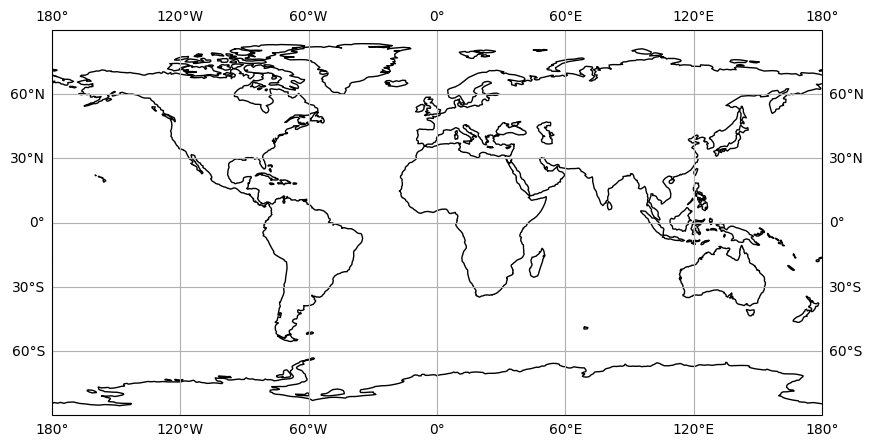

In [89]:
i = 9
plot_contour_map(ds_grid['lat'], ds_grid['lon'], predictions[:,i], title='Predictions')

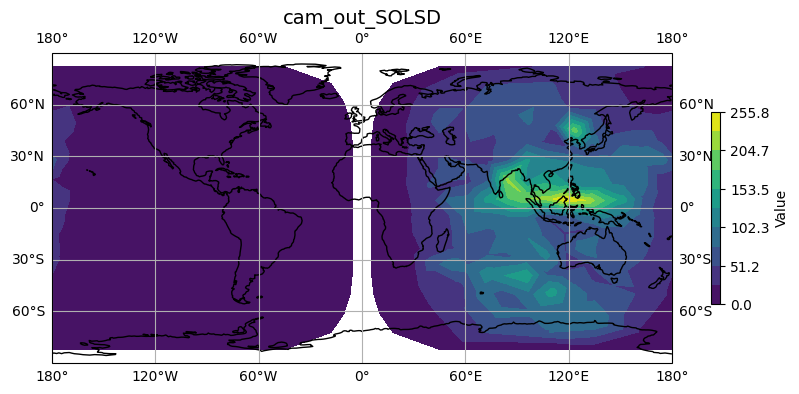

In [56]:
i = 8
plot_contour_map(ds_grid['lat'], ds_grid['lon'], dso.values[:,i], title=vars_mlo[i])

/home/alvarovh/.conda/envs/climsim_env/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/tmp/ipykernel_4187478/3415965012.py:46: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="lower left")


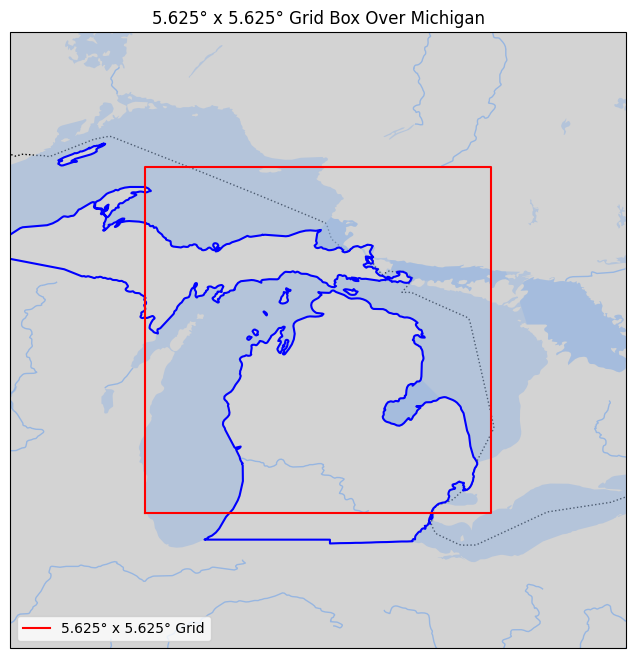

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader

# Set up the map projection and area of interest
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-90, -80, 40, 50], crs=ccrs.PlateCarree())  # Michigan region

# Add geographic features
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgrey")
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot Michigan boundary from shapefile
shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces_lakes')
for record in Reader(shapefile).records():
    if record.attributes['name'] == 'Michigan':  # Filter for Michigan
        geometry = record.geometry
        ax.add_geometries([geometry], ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linewidth=1.5, label="Michigan Boundary")

# Define the grid box dimensions (5.625° x 5.625°) in Michigan area
latitude = 45  # Center of Michigan latitude for demonstration
longitude = -85  # Center of Michigan longitude for demonstration

# Calculate the box corners
lat_min = latitude - 5.625 / 2
lat_max = latitude + 5.625 / 2
lon_min = longitude - 5.625 / 2
lon_max = longitude + 5.625 / 2

# Plot the box on the map
ax.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],
    [lat_min, lat_min, lat_max, lat_max, lat_min],
    color="red",
    transform=ccrs.PlateCarree(),
    label="5.625° x 5.625° Grid"
)

# Add labels and legend
ax.set_title("5.625° x 5.625° Grid Box Over Michigan")
ax.legend(loc="lower left")

plt.show()


<bound method Axes.legend of <GeoAxes: title={'center': '1.40625° x 1.40625° Grid Box Over Michigan'}>>

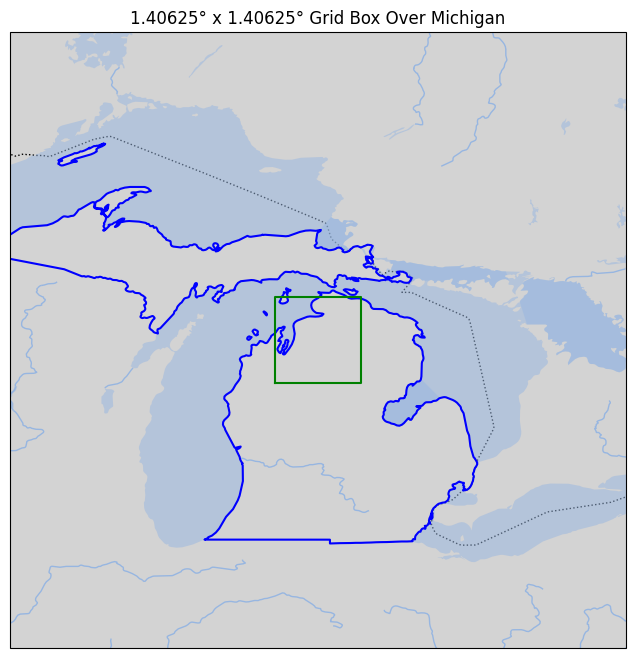

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader

# Set up the map projection and area of interest
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-90, -80, 40, 50], crs=ccrs.PlateCarree())  # Michigan region

# Add geographic features
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgrey")
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot Michigan boundary from shapefile
shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces_lakes')
for record in Reader(shapefile).records():
    if record.attributes['name'] == 'Michigan':  # Filter for Michigan
        geometry = record.geometry
        ax.add_geometries([geometry], ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linewidth=1.5, label="Michigan Boundary")

# Define the grid box dimensions (1.40625° x 1.40625°) in Michigan area
latitude = 45  # Center of Michigan latitude for demonstration
longitude = -85  # Center of Michigan longitude for demonstration

# Calculate the box corners
lat_min = latitude - 1.40625 / 2
lat_max = latitude + 1.40625 / 2
lon_min = longitude - 1.40625 / 2
lon_max = longitude + 1.40625 / 2

# Plot the box on the map
ax.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],
    [lat_min, lat_min, lat_max, lat_max, lat_min],
    color="green",
    transform=ccrs.PlateCarree(),
    label="1.40625° x 1.40625° Grid"
)

# Add labels and legend
ax.set_title("1.40625° x 1.40625° Grid Box Over Michigan")
ax.legend


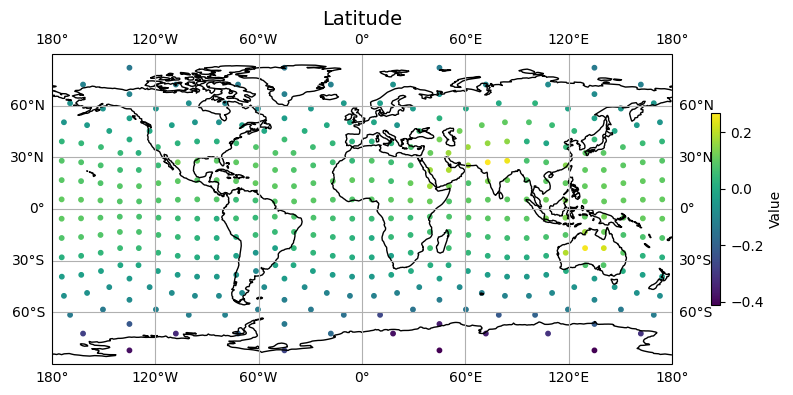

In [58]:
plot_lat_lon_data(ds_grid['lat'], ds_grid['lon'], input_data[:,-1], title='Latitude', save_path=None)

In [ ]:
def plot_metric_map(ds_plotdata, kmetric='R2', kvar='cam_out_PRECSC', klev=-1,
                    cmap='jet', vmin=0., vmax=1., clev=11,
                    fn_fig=''):
    # Define the figure and each axis for the 2 rows and 3 columns
    fig, ax = plt.subplots(nrows=1,ncols=1,
                            subplot_kw={'projection': ccrs.Robinson(central_longitude=179.5)},
                            figsize=(8.,3.))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    ax=ax.flatten()

    #Loop over all of the models
    # for k, kmodel in enumerate(plot_this_models):
        # ax = axs[k]
    # ax.set_global()

    # ds_plotdata = PLOTDATA[kmetric][kmodel]

    x = ds_grid['lon']
    y = ds_grid['lat']
    z = ds_plotdata[vars_mlo[0]]
    
    # if klev>=0: z = z.isel(lev=klev)
    
    # if kmetric=='R2':
    #     z = z.where(z>0,-1e-5)
    clevels = np.linspace(vmin,vmax,clev)
    h = ax.tricontourf(x, y, z, transform=ccrs.PlateCarree(),
                        levels = clevels, 
                        cmap=cmap, 
                        extend='min' if kmetric=='R2' else 'both')
    h.cmap.set_under('silver')
    if kmetric=='R2':        h.set_clim(1e-5, 1.)

    # # Contour plot
    # cs=axs[i].contourf(lons,ds['lat'],data,
    #                   transform = ccrs.PlateCarree(),
    #                   cmap='coolwarm',extend='both')

    # ax.set_title(f'({abc[k]}) {kmodel}')
    ax.coastlines()

# # fig.suptitle(kvar, y=1.025)
# fig.suptitle(vars_longname[kvar] + (f' (level={klev})' if klev>=0 else ''),
#              y=1.02)
tmp = vars_longname[kvar]
if klev>=0:
    tmp = tmp + (f' (level={klev})' if klev>=0 else '')
tmp = tmp.split(',')
tmp = f'{tmp[1]}\n{tmp[0]}'
fig.text(.087,.5, tmp,ha='center', va='center', rotation=90)
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.925, 0.145, 0.020, 0.71])
cbar_ax.set_title(kmetric)
fig.colorbar(h, cax=cbar_ax, ticks=[0,0.25,0.5,0.75,1])
fig.set_facecolor('w')

if len(fn_fig)>0:
    fig.savefig(fn_fig)

In [24]:
groundtruth[vars_mlo]

KeyError: 'ptend_t'

In [21]:
# save to file
np.savez("predictions.npz", predictions=predictions, input_data=input_data, vars_mlo=vars_mlo, groundtruth=groundtruth)
# can be loaded with np.load("predictions.npz")

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_dataarray()` method.

In [46]:
input_data.shape

(384, 125)

In [45]:
predictions.shape

(384, 128)

In [47]:
mlo_scale

<xarray.Dataset> Size: 1kB
Dimensions:         (lev: 60)
Dimensions without coordinates: lev
Data variables:
    ptend_t         (lev) float64 480B ...
    ptend_q0001     (lev) float64 480B ...
    cam_out_NETSW   float64 8B ...
    cam_out_FLWDS   float64 8B ...
    cam_out_PRECSC  float64 8B ...
    cam_out_PRECC   float64 8B ...
    cam_out_SOLS    float64 8B ...
    cam_out_SOLL    float64 8B ...

In [42]:
# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Make predictions
# predictions, input_data, vars_mlo, mlo_scale = make_predictions(
#     input_file, model, vars_mli, vars_mlo, mli_mean, mli_max, mli_min, mlo_scale, output_dir
# )
predictions, ground_truth = make_predictions(
    input_file, model, vars_mli, vars_mlo, mli_mean, mli_max, mli_min, mlo_scale, output_dir
)


Processing input file: /nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all//datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0006-07/E3SM-MMF.mli.0006-07-06-43200.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


ValueError: too many values to unpack (expected 2)

In [ ]:
input_data.shape

In [ ]:
predictions.shape

In [ ]:
mlo_scale

In [ ]:
#xarray to numpy array
mloscalenp= mlo_scale.to_array().values
mloscalenp.shape

In [ ]:
mloscalenp

In [ ]:
# Flatten `mlo_scale` to extract variables
scaling_factors = []

# Add variables with multiple levels
for var in ['ptend_t', 'ptend_q0001', 'ptend_q0002', 'ptend_q0003', 'ptend_u', 'ptend_v']:
    scaling_factors.extend(mlo_scale[var].values)  # Add all levels

# Add scalar variables
for var in ['cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 
            'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']:
    scaling_factors.append(mlo_scale[var].values)

# Convert to numpy array
scaling_factors = np.array(scaling_factors)

# Ensure shape matches predictions
if scaling_factors.shape[0] != predictions.shape[1]:
    raise ValueError(f"Mismatch in scaling factors ({scaling_factors.shape[0]}) and predictions ({predictions.shape[1]})!")
